# Exploring Wave Spectra Variables from the Spotter Archive

See [Spotter Technical Manual](https://content.sofarocean.com/hubfs/Spotter%20product%20documentation%20page/Sofar%20-%20Technical_Reference_Manual.pdf) for details on wave spectra from directional wave buoys like Spotter.

This notebook demonstrates plotting from zarr files stored on S3. Here, we inspect time series of bulk parameters and color-coded wave spectra from SPOT-0627, which sampled TC Niran in 2021 (see [Sofar blog](https://www.sofarocean.com/posts/improving-hurricane-observations-with-data-from-scalable-sensor-networks) for further context).

All data access methods remain the same if using the netCDF file downloaded locally, e.g., following `ds = xr.load_dataset(local_filename)`. The xarray + zarr allows for efficient remote access of the data without full download, but does require internet connection.

In [1]:
# Import necessary packages (you may need to pip install in your environment)

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import xarray as xr

import numpy as np

## Option A: Load netcdf dataset with xarray + zarr

In [2]:
# open the file using xarray and zarr

s3_uri = "https://sofar-spotter-archive.s3.amazonaws.com/spotter_data_spectra_zarr"
ds = xr.open_dataset(s3_uri, engine="zarr")
ds

<xarray.Dataset>
Dimensions:                (index: 4052309, frequency: 49, trajectory: 760)
Coordinates:
  * frequency              (frequency) float64 0.0293 0.03906 ... 0.4883 0.498
    time                   (index) datetime64[ns] ...
  * trajectory             (trajectory) object 'SPOT-010001' ... 'SPOT-1975'
Dimensions without coordinates: index
Data variables:
    a1                     (index, frequency) float64 ...
    a2                     (index, frequency) float64 ...
    b1                     (index, frequency) float64 ...
    b2                     (index, frequency) float64 ...
    latitude               (index) float64 ...
    longitude              (index) float64 ...
    rowsize                (trajectory) int64 ...
    significantWaveHeight  (index) float64 ...
    u10                    (index) float64 ...
    variance_density       (index, frequency) float64 ...
Attributes:
    author:         Isabel A. Houghton
    creation_date:  2023-10-18 01:34:54.632351
    email:          isabel.houghton@sofarocean.com
    institution:    Sofar Ocean
    references:     https://content.sofarocean.com/hubfs/Spotter%20product%20...
    source:         Spotter wave buoy
    title:          Sofar Spotter Data Archive - Spectral Wave Parameters and...

## Option B: Load from local netCDF file
- comment out zarr access above / uncomment block below
- update local_filepath to correspond to where .nc file is downloaded on your local machine

In [3]:
# local_filename = "~/Downloads/spotter_data_spectra.nc"
# ds = xr.load_dataset(local_filename)
# ds

## Plot data from single drifter

In [4]:
# choose a drifter by ID
spotter_id = 'SPOT-0627'


# create an array that points to indices for each trajectory (and insert 0 index at beginning of array)
traj_idx = np.insert(np.cumsum(ds.rowsize.values), 0, 0)


# find index of chosen drifter
j = np.where(ds.trajectory==spotter_id)[0][0]
print(f"Drifter index for {spotter_id} is {j}")


# create the slice index `sli` for data from that drifter
sli = slice(traj_idx[j], traj_idx[j+1])

# select from the dataset based on index slice - `selected_ds` now only contains data from specified Spotter
selected_ds = ds.sel(index=sli)

Drifter index for SPOT-0627 is 351


### Plot time series of significant wave height (H$_s$) 

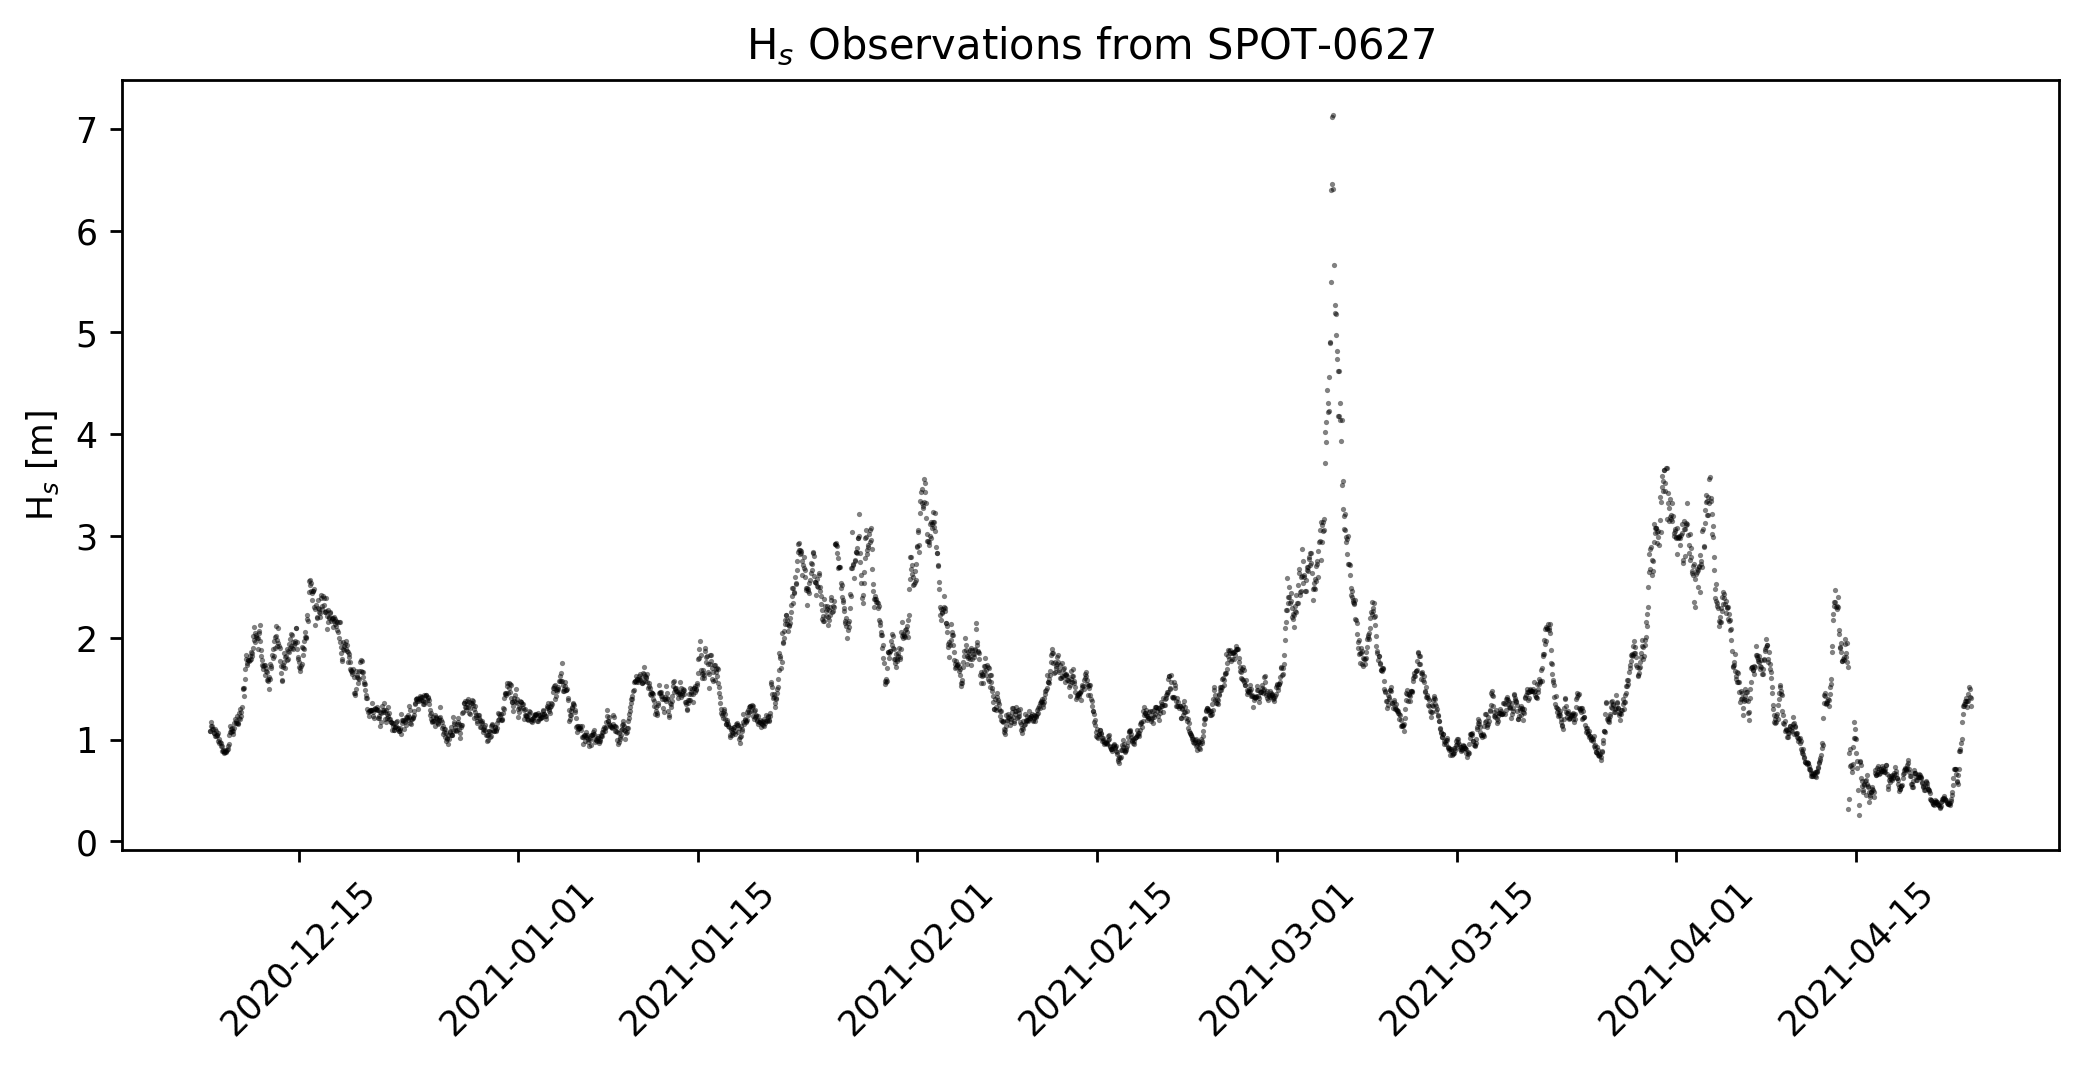

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,4), dpi=250)
ax.scatter(selected_ds.time, selected_ds.significantWaveHeight, c='k',alpha=0.5, marker='.', s=1)

plt.xticks(rotation=45)
plt.ylabel('H$_s$ [m]')
plt.title(f"H$_s$ Observations from {spotter_id}")
plt.show()

### Plot time series of inferred windspeed (U10) 
See [Sofar wind inference blog](https://www.sofarocean.com/posts/updated-algorithm-improves-accuracy-spotter-wind-measurement) for more details.

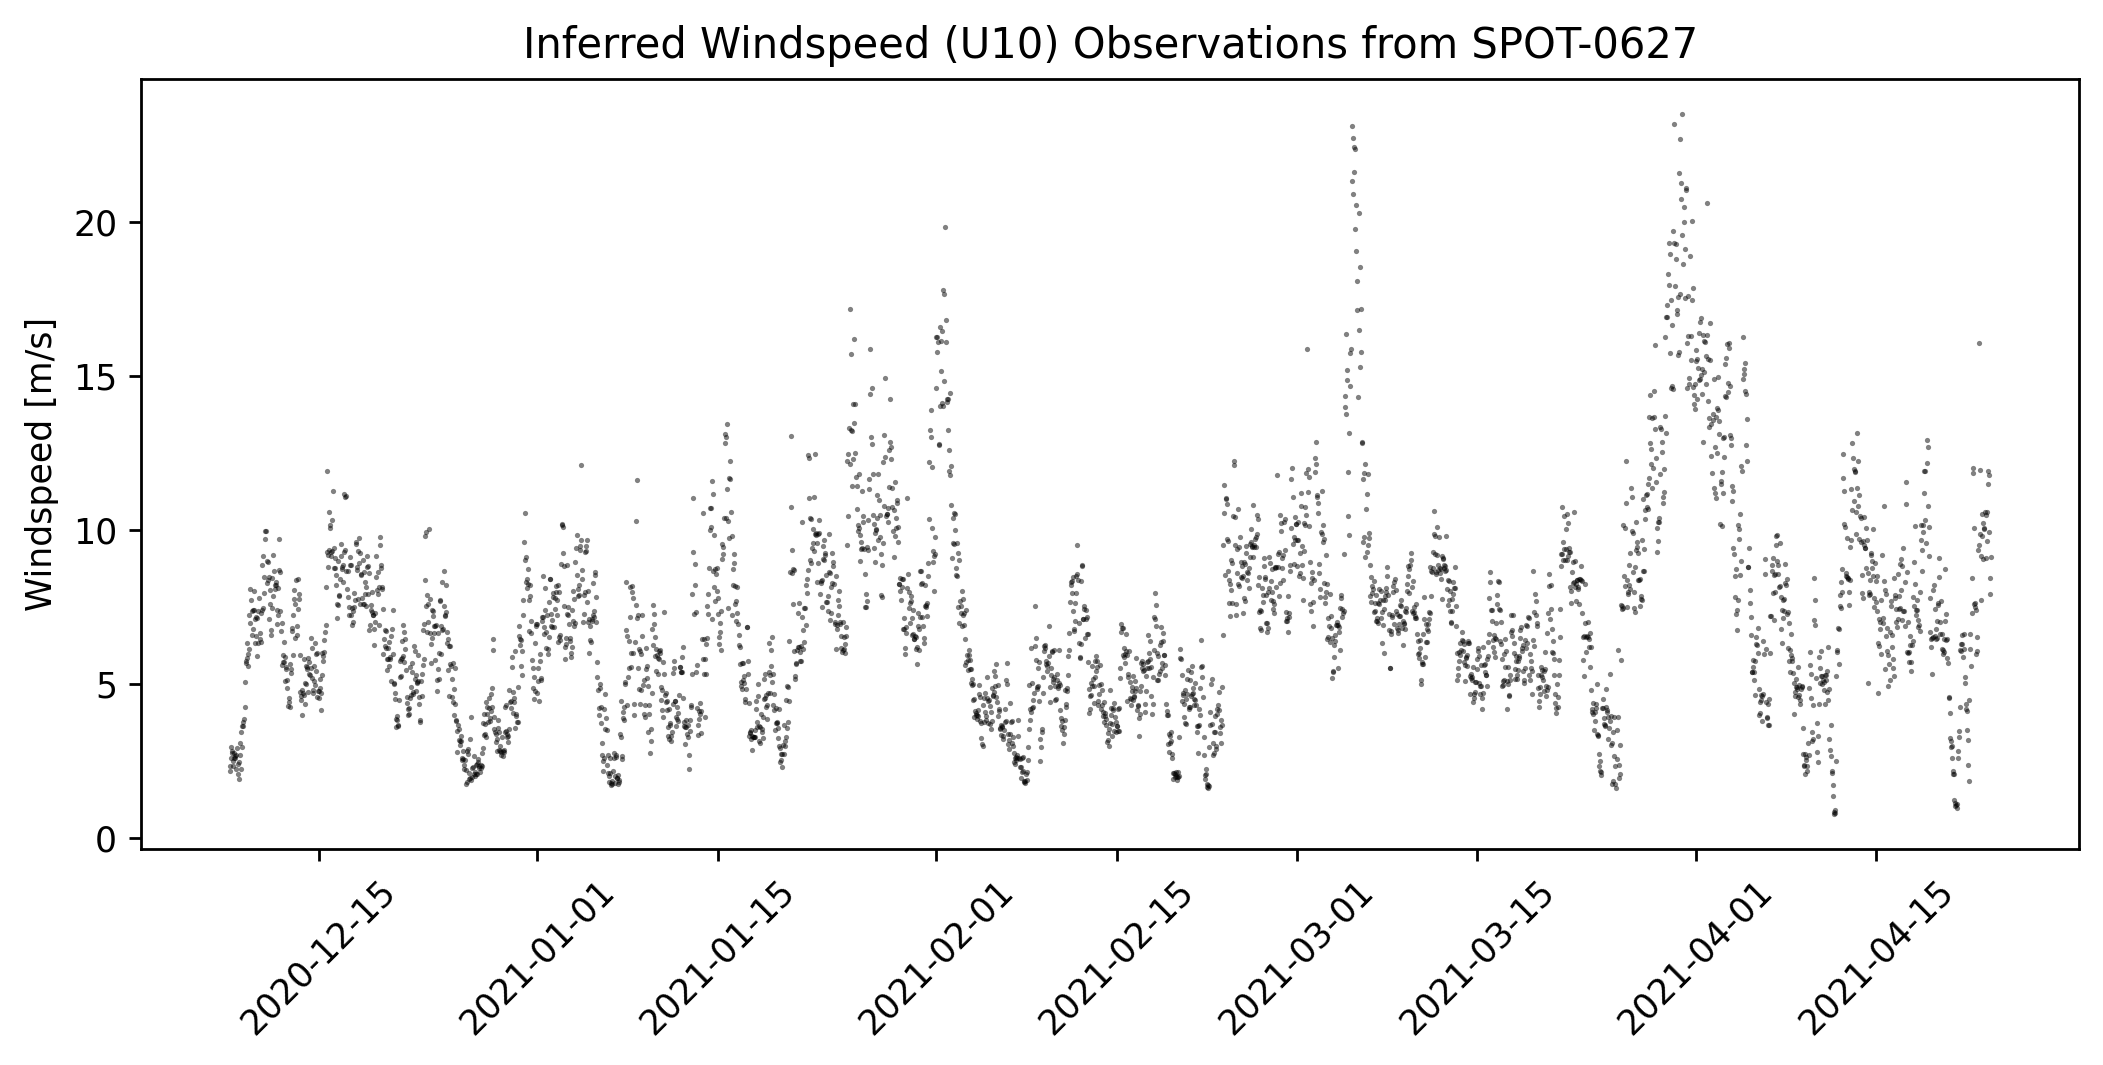

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,4), dpi=250)
ax.scatter(selected_ds.time, selected_ds.u10, c='k',alpha=0.5, marker='.', s=1)

plt.xticks(rotation=45)
plt.ylabel('Windspeed [m/s]')
plt.title(f"Inferred Windspeed (U10) Observations from {spotter_id}")
plt.show()

## Plot variance density (1D wave spectrum) colored by time

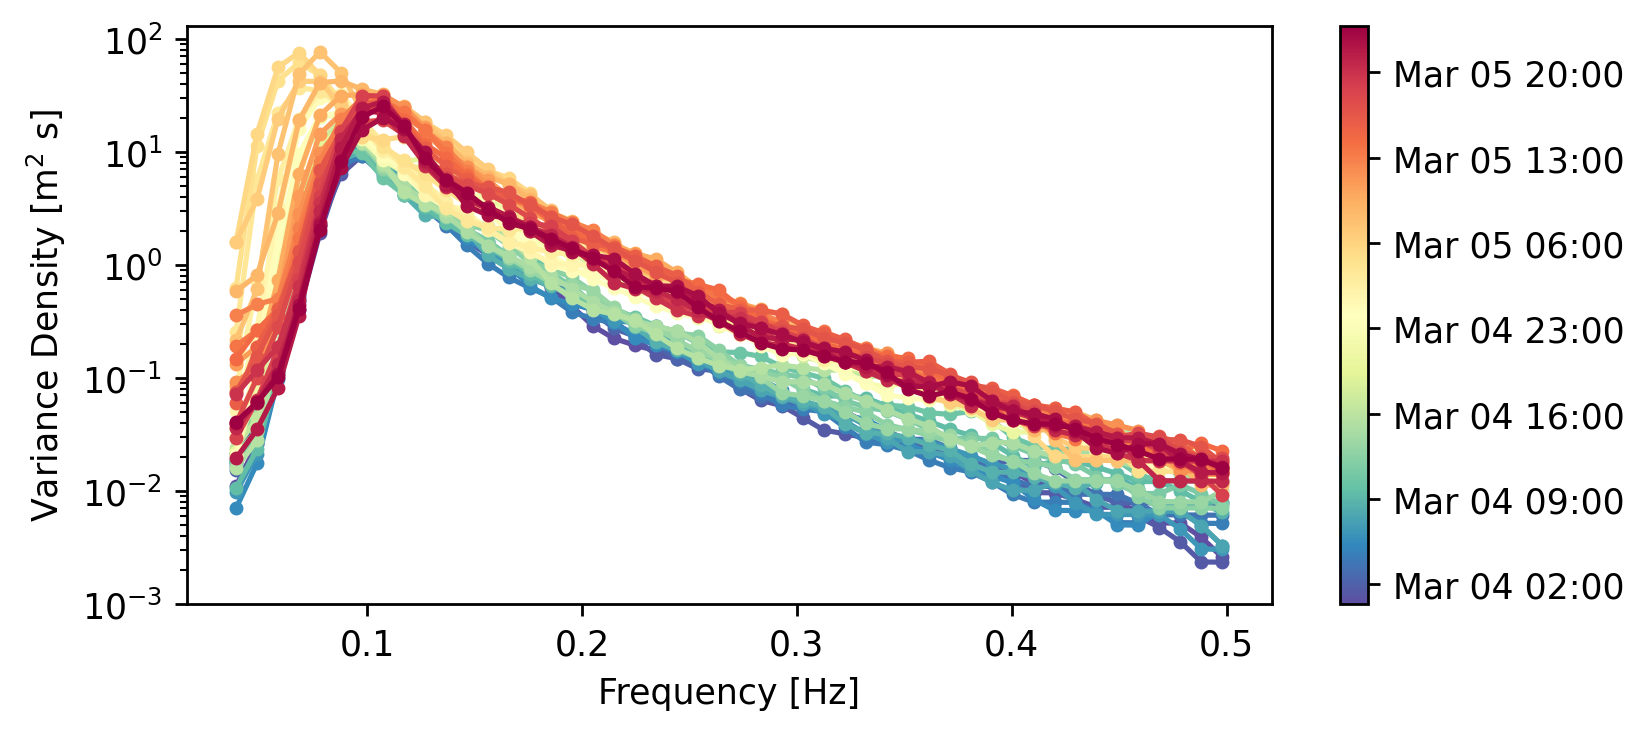

In [7]:
# specify start and end time of interest
target_time_start = np.datetime64('2021-03-04T00:00')
target_time_end = np.datetime64('2021-03-06T00:00')

# select from dataset that has already been reduced to a single Spotter
selected_ds =  selected_ds.where((selected_ds.time>target_time_start)&(selected_ds.time<target_time_end), drop=True)

# generate colors to cycle through
color_list = cm.Spectral_r(np.linspace(0, 1, len(selected_ds.significantWaveHeight)))
fig = plt.figure(figsize=(7,3), dpi=250)
ax = fig.add_subplot(1,1,1)

# plot each wave spectrum with a different color corresponding to time
for ind, color in enumerate(color_list):
    ax.plot(selected_ds.frequency,
            selected_ds.variance_density[ind, :],
            marker='.', 
            c=color)
    
ax.set(xlabel="Frequency [Hz]", ylabel="Variance Density [m$^2$ s]")
ax.set_yscale('log')
ax.set_ylim(1e-3, )
sm = cm.ScalarMappable(cmap="Spectral_r", 
                       norm=plt.Normalize(vmin=selected_ds.time.min(),
                                          vmax=selected_ds.time.max()))

cbar = plt.colorbar(sm, ax=ax)
vals = cbar.ax.get_yticks()[1:-1]
cbar.ax.yaxis.set_ticks(vals)

# Change the numeric ticks into ones that match the x-axis
cbar.ax.set_yticklabels(pd.to_datetime(vals).strftime(date_format='%b %d %H:00'))
plt.show()

## Plot variance density (1D spectrum) colored by H$_s$

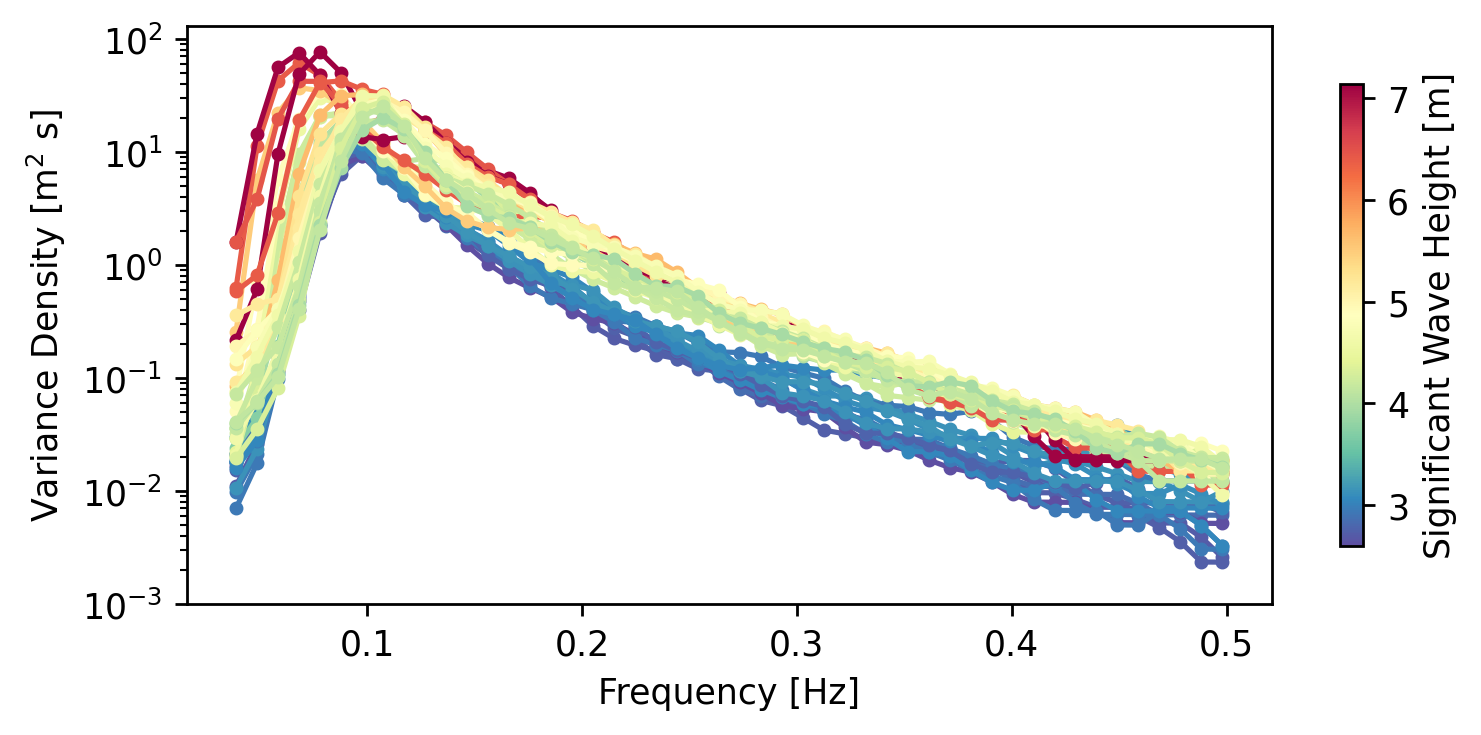

In [8]:
fig = plt.figure(figsize=(7,3), dpi=250)
ax = fig.add_subplot(1,1,1)

hs = selected_ds.significantWaveHeight

# plot each wave spectrum with a different color corresponding to Hs
for ind in range(len(hs)):
    # calculate a float value [0,1] that corresponds to waveheight to specify color
    color_float = (hs[ind].values-hs.min())/(hs.max()-hs.min())
    ax.plot(selected_ds.frequency,
            selected_ds.variance_density[ind, :],
            marker='.', 
            c=cm.Spectral_r(color_float))
    
ax.set(xlabel="Frequency [Hz]", ylabel="Variance Density [m$^2$ s]")
ax.set_yscale('log')
ax.set_ylim(1e-3, )

sm = cm.ScalarMappable(cmap="Spectral_r", 
                       norm=plt.Normalize(vmin=hs.min(),
                                          vmax=hs.max()))

cbar = plt.colorbar(sm, ax=ax, label='Significant Wave Height [m]', shrink=0.8)
plt.show()